#### 1 Revisión de los datos
Primero se importaron las librerías necesarias para trabajar con los datos. Después se cargó el archivo A3.1_Khan.csv usando pandas y se imprimieron sus dimensiones para saber cuántas filas y columnas tenía el conjunto de datos. También se revisó si había valores faltantes y se mostraron las primeras cinco filas para observar la estructura de la base.

Luego se separó la información: por un lado quedaron todas las columnas de los genes (X) y por otro la columna “y”, que indica el tipo de cáncer (con valores del 1 al 4). Después se filtraron los datos para quedarnos solo con las muestras de las clases 2 y 4, ya que entre ellas se iba a comparar la expresión de los genes. Finalmente, se calcularon las medias de cada gen en ambas clases y se obtuvo la diferencia absoluta entre esos promedios. Con eso se imprimieron los 10 genes con mayor diferencia de medias, que son los que muestran más variación entre los dos tipos de cáncer analizados.

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests

df = pd.read_csv("A3.1_Khan.csv")
print("Shape:", df.shape)
print("Huecos totales:", df.isna().sum().sum())
display(df.head())

X = df.drop(columns=["y"])
y = df["y"].astype(int)

X2 = X[y == 2]
X4 = X[y == 4]

delta_abs = (X2.mean() - X4.mean()).abs().sort_values(ascending=False)
print("\nTop-10 |media(clase2) - media(clase4)|")
display(delta_abs.head(10).to_frame(name="|Δ medias|"))

Shape: (83, 2309)
Huecos totales: 0


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X2300,X2301,X2302,X2303,X2304,X2305,X2306,X2307,X2308,y
0,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,0.565427,...,-0.027474,-1.660205,0.588231,-0.463624,-3.952845,-5.496768,-1.414282,-0.647600,-1.763172,2
1,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,0.159053,...,-0.246284,-0.836325,-0.571284,0.034788,-2.478130,-3.661264,-1.093923,-1.209320,-0.824395,2
2,-0.084469,-1.649739,-0.241308,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,0.496585,...,0.024985,-1.059872,-0.403767,-0.678653,-2.939352,-2.736450,-1.965399,-0.805868,-1.139434,2
3,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,0.994732,...,0.357115,-1.893128,0.255107,0.163309,-1.021929,-2.077843,-1.127629,0.331531,-2.179483,2
4,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,0.278313,...,0.061753,-2.273998,-0.039365,0.368801,-2.566551,-1.675044,-1.082050,-0.965218,-1.836966,2



Top-10 |media(clase2) - media(clase4)|


,|Δ medias|
X187,3.323151
X509,2.906537
X2046,2.424515
X2050,2.401783
X129,2.165185
X1645,2.065460
X1319,2.045941
X1955,2.037340
X1003,2.011337
X246,1.837830


#### 2 Comparación estadística entre las clases 2 y 4
En este punto se compararon las medias de cada gen entre las clases 2 y 4 usando la prueba t de Student, que permite identificar si las diferencias entre ambos grupos son estadísticamente significativas. Para cada gen se calcularon un valor t y un p-value; cuanto más pequeño es el p-value, mayor es la probabilidad de que exista una diferencia real entre las clases.

Como se realizaron muchas pruebas a la vez (una por cada gen), se aplicaron tres métodos de corrección para evitar falsos positivos: Bonferroni, Holm y Benjamini-Hochberg (BH-FDR). Bonferroni es el más estricto, Holm un poco más flexible y BH-FDR el más permisivo, permitiendo conservar un mayor número de genes significativos.

Al final se mostró cuántos genes resultaron significativos con cada método y se imprimieron los 10 genes más importantes de cada uno. Esto permitió comparar los resultados y observar qué genes fueron consistentes entre los distintos métodos de corrección.

In [21]:
import scipy.stats as stats

genes = [c for c in df.columns if c != "y"]
grupo_2 = df[df["y"] == 2]
grupo_4 = df[df["y"] == 4]

p_vals = []
t_stats = []
for g in genes:
    t, p = stats.ttest_ind(grupo_2[g], grupo_4[g], equal_var=False, nan_policy='omit')
    t_stats.append(t)
    p_vals.append(p)

res_t = pd.DataFrame({"Gene": genes, "t_stat": t_stats, "p": p_vals})

rej_bonf, p_bonf, _, _ = multipletests(res_t["p"], alpha=0.05, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(res_t["p"], alpha=0.05, method="holm")
rej_bh,   p_bh,   _, _ = multipletests(res_t["p"], alpha=0.05, method="fdr_bh")

res_t["p_bonf"] = p_bonf
res_t["p_holm"] = p_holm
res_t["p_bh"]   = p_bh
res_t["sig_bonf"] = rej_bonf
res_t["sig_holm"] = rej_holm
res_t["sig_bh"]   = rej_bh

print("Genes significativos (α=0.05)")
print("  Bonferroni:", int(res_t["sig_bonf"].sum()))
print("  Holm      :", int(res_t["sig_holm"].sum()))
print("  BH-FDR    :", int(res_t["sig_bh"].sum()))

print("\nTop-10 Bonferroni:")
display(res_t[res_t["sig_bonf"]].sort_values("p_bonf")[["Gene", "p_bonf"]].head(10))

print("\nTop-10 Holm:")
display(res_t[res_t["sig_holm"]].sort_values("p_holm")[["Gene", "p_holm"]].head(10))

print("\nTop-10 BH-FDR:")
display(res_t[res_t["sig_bh"]].sort_values("p_bh")[["Gene", "p_bh"]].head(10))

Genes significativos (α=0.05)
  Bonferroni: 72
  Holm      : 72
  BH-FDR    : 296

Top-10 Bonferroni:


,Gene,p_bonf
1002,X1003,1.153698e-13
186,X187,8.578576e-13
2049,X2050,9.427801e-12
1954,X1955,1.224885e-11
1644,X1645,1.907075e-11
245,X246,3.548567e-11
2045,X2046,4.083533e-11
508,X509,1.743776e-10
1953,X1954,2.193537e-10
1388,X1389,1.474328e-09



Top-10 Holm:


,Gene,p_holm
1002,X1003,1.153698e-13
186,X187,8.574859e-13
2049,X2050,9.419631e-12
1954,X1955,1.223293e-11
1644,X1645,1.903770e-11
245,X246,3.540879e-11
2045,X2046,4.072917e-11
508,X509,1.738487e-10
1953,X1954,2.185934e-10
1388,X1389,1.468579e-09



Top-10 BH-FDR:


,Gene,p_bh
1002,X1003,1.153698e-13
186,X187,4.289288e-13
1954,X1955,3.062213e-12
2049,X2050,3.062213e-12
1644,X1645,3.814150e-12
245,X246,5.833619e-12
2045,X2046,5.833619e-12
508,X509,2.179720e-11
1953,X1954,2.437263e-11
1388,X1389,1.474328e-10


#### Análisis de varianza (ANOVA) entre las cuatro clases
En este paso se usó la prueba ANOVA de una vía para comparar las medias de los genes entre las cuatro clases (1, 2, 3 y 4).

Primero se separaron los datos por clase y después, para cada gen, se aplicó la función f_oneway, que calcula el estadístico F y su respectivo p-value.
El estadístico F sirve para medir si al menos una de las clases tiene una media diferente en comparación con las demás.

Al igual que antes, se aplicaron tres métodos de corrección por múltiples pruebas: Bonferroni, Holm y Benjamini-Hochberg (BH-FDR), para reducir la posibilidad de falsos positivos. Después se contó cuántos genes resultaron significativos con cada método y se mostraron los 10 genes más importantes según BH-FDR.

Este análisis permite identificar los genes cuya expresión cambia significativamente entre los cuatro tipos de cáncer, lo que puede ayudar a encontrar patrones generales de diferencia entre las clases.

In [13]:
clase1 = df[df["y"] == 1]
clase2 = df[df["y"] == 2]
clase3 = df[df["y"] == 3]
clase4 = df[df["y"] == 4]

f_stats, p_vals_a = [], []
for g in genes:
    F, p = f_oneway(clase1[g].dropna(), clase2[g].dropna(), clase3[g].dropna(), clase4[g].dropna())
    f_stats.append(F); p_vals_a.append(p)

res_a = pd.DataFrame({"Gene": genes, "F": f_stats, "p": p_vals_a})

rej_bonf_a, p_bonf_a, _, _ = multipletests(res_a["p"], alpha=0.05, method="bonferroni")
rej_holm_a, p_holm_a, _, _ = multipletests(res_a["p"], alpha=0.05, method="holm")
rej_bh_a,   p_bh_a,   _, _ = multipletests(res_a["p"], alpha=0.05, method="fdr_bh")

res_a["p_bonf"] = p_bonf_a; res_a["p_holm"] = p_holm_a; res_a["p_bh"] = p_bh_a
res_a["sig_bonf"] = rej_bonf_a; res_a["sig_holm"] = rej_holm_a; res_a["sig_bh"] = rej_bh_a

print("Significativos ANOVA (α=0.05):")
print("  Bonferroni:", int(res_a["sig_bonf"].sum()))
print("  Holm      :", int(res_a["sig_holm"].sum()))
print("  BH-FDR    :", int(res_a["sig_bh"].sum()))

print("\nTop-10 BH-FDR (ANOVA):")
display(res_a[res_a["sig_bh"]].sort_values("p_bh")[["Gene","p_bh"]].head(10))

Significativos ANOVA (α=0.05):
  Bonferroni: 404
  Holm      : 412
  BH-FDR    : 1162

Top-10 BH-FDR (ANOVA):


,Gene,p_bh
1954,X1955,2.045755e-21
1388,X1389,2.045755e-21
1002,X1003,1.245542e-20
2049,X2050,2.731346e-19
245,X246,3.062126e-19
741,X742,8.445542e-19
0,X1,1.265852e-17
2161,X2162,2.986387e-17
1953,X1954,5.597246e-17
186,X187,6.751740e-17


#### Entrenamiento de modelos SVM con distintos kernels
En este paso se usaron los resultados del ANOVA para seleccionar los 200 genes más significativos, es decir, los que tenían los valores de p más bajos. Esto se hace para reducir la cantidad de variables y que el entrenamiento de los modelos sea más rápido.

Después, con esos genes seleccionados, se dividió el conjunto de datos en dos partes:

- 70 % para entrenamiento
- 30 % para prueba

manteniendo el mismo número proporcional de muestras por clase (gracias a stratify=y).

Luego se entrenaron tres modelos SVM (Support Vector Machine) usando distintos tipos de kernel:

- Lineal, que separa las clases con una línea o un plano.

- Polinomial de grado 3, que crea una frontera más curva y compleja.

- RBF (Radial Basis Function), que es más flexible y puede adaptarse a formas no lineales.

Antes del entrenamiento, los datos se estandarizaron con StandardScaler para que todos los genes tuvieran una escala similar, lo cual mejora el desempeño del modelo. Finalmente, se entrenaron los tres modelos con los datos de entrenamiento y se confirmó que los tres kernels quedaron listos para evaluar su rendimiento en el siguiente paso.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Seleccionar N genes con menor p_bh del ANOVA
N = 200  # ajusta si necesitas
top_feats = (res_a.sort_values("p_bh").head(N)["Gene"].tolist())

X_sel = df[top_feats]
y = df["y"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.3, random_state=42, stratify=y
)

svm_lin  = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="linear", C=1, random_state=42))])
svm_poly = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="poly", degree=3, C=1, random_state=42))])
svm_rbf  = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="rbf", gamma="scale", C=1, random_state=42))])

svm_lin.fit(X_train, y_train)
svm_poly.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)
print("Modelos entrenados: lineal, polinomial(g=3) y RBF")

Modelos entrenados: lineal, polinomial(g=3) y RBF


#### Evaluación de los modelos y comparación visual
En este paso se evaluó el desempeño de los tres SVM (lineal, polinomial grado 3 y RBF) usando el conjunto de prueba.
Primero se generaron las predicciones (y_pred_*) y se calcularon dos métricas globales:

- Accuracy: proporción total de aciertos.

- F1: promedio del equilibrio entre precisión y recall en cada clase, ponderado por el tamaño de la clase (útil cuando hay clases con distinto número de muestras).

Después se construyeron las matrices de confusión para cada modelo. Cada matriz muestra, por clase, cuántas observaciones se clasificaron correctamente (diagonal) y dónde hubo errores (fuera de la diagonal). Finalmente, se graficaron las tres matrices lado a lado con un mapa de color (plasma) para ver rápidamente qué modelo confunde menos. El título de cada gráfico incluye el Accuracy de ese kernel para facilitar la comparación visual.

=== Métricas de desempeño ===
Lineal     → Accuracy: 1.000 | F1: 1.000
Polinomial → Accuracy: 0.880 | F1: 0.877
RBF        → Accuracy: 1.000 | F1: 1.000


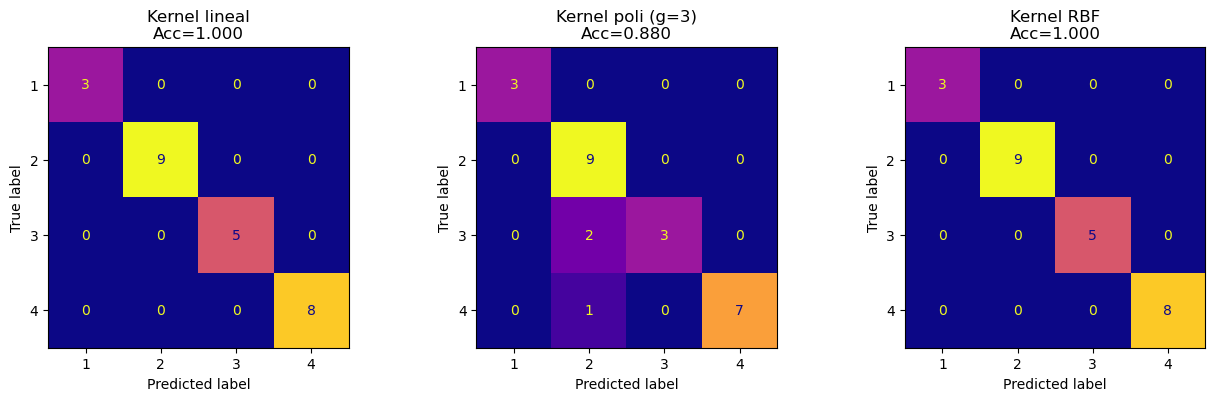

In [17]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred_lin  = modelos["Linear"].predict(X_test)
y_pred_poly = modelos["Poly(3)"].predict(X_test)
y_pred_rbf  = modelos["RBF"].predict(X_test)

acc_lin  = accuracy_score(y_test, y_pred_lin)
acc_poly = accuracy_score(y_test, y_pred_poly)
acc_rbf  = accuracy_score(y_test, y_pred_rbf)

f1_lin  = f1_score(y_test, y_pred_lin, average="weighted")
f1_poly = f1_score(y_test, y_pred_poly, average="weighted")
f1_rbf  = f1_score(y_test, y_pred_rbf, average="weighted")

print("=== Métricas de desempeño ===")
print(f"Lineal     → Accuracy: {acc_lin:.3f} | F1: {f1_lin:.3f}")
print(f"Polinomial → Accuracy: {acc_poly:.3f} | F1: {f1_poly:.3f}")
print(f"RBF        → Accuracy: {acc_rbf:.3f} | F1: {f1_rbf:.3f}")

labels = sorted(np.unique(y_test))
cm_lin  = confusion_matrix(y_test, y_pred_lin,  labels=labels)
cm_poly = confusion_matrix(y_test, y_pred_poly, labels=labels)
cm_rbf  = confusion_matrix(y_test, y_pred_rbf,  labels=labels)

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

disp_lin  = ConfusionMatrixDisplay(cm_lin,  display_labels=labels)
disp_poly = ConfusionMatrixDisplay(cm_poly, display_labels=labels)
disp_rbf  = ConfusionMatrixDisplay(cm_rbf,  display_labels=labels)

disp_lin.plot(ax=axes[0], cmap="plasma", colorbar=False, values_format="d")
axes[0].set_title(f"Kernel lineal\nAcc={acc_lin:.3f}")

disp_poly.plot(ax=axes[1], cmap="plasma", colorbar=False, values_format="d")
axes[1].set_title(f"Kernel poli (g=3)\nAcc={acc_poly:.3f}")

disp_rbf.plot(ax=axes[2], cmap="plasma", colorbar=False, values_format="d")
axes[2].set_title(f"Kernel RBF\nAcc={acc_rbf:.3f}")

for ax in axes:
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

Los resultados muestran que los tres modelos SVM lograron clasificar correctamente la mayoría de las muestras, pero con diferencias en su precisión. El modelo con kernel lineal y el kernel RBF obtuvieron un 100 % de exactitud (Accuracy = 1.0) y un F1-score de 1.0, lo que significa que predijeron correctamente todas las clases sin cometer errores.

Por otro lado, el modelo con kernel polinomial de grado 3 tuvo un accuracy de 0.88 y un F1-score de 0.877, mostrando algunos errores al confundir principalmente las clases 3 y 4. Esto indica que el modelo polinomial fue más sensible al sobreajuste o que la frontera entre esas clases no se ajusta bien a una función polinómica.

Las matrices de confusión permiten visualizar estas diferencias: mientras los kernels lineal y RBF tienen diagonales perfectas (sin errores), el polinomial presenta algunas predicciones fuera de la diagonal. En conjunto, estos resultados demuestran que los datos de expresión génica en este caso son linealmente separables, por lo que los modelos lineal y RBF son los más adecuados para este tipo de clasificación.